# Data pre-processing and clenup 
We will be using the spacy library.   
https://allenai.github.io/scispacy/

In [2]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_sm
import en_core_sci_md
import pandas as pd
from tqdm import tqdm
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

In [53]:
!python3 -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.7) =================
ℹ spaCy installation:
/Users/dantohe/Library/Python/3.8/lib/python/site-packages/spacy

NAME             SPACY            VERSION                            
en_core_sci_md   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_sci_sm   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_web_sm   >=3.0.0,<3.1.0   3.0.0   ✔



### Importing Spacy data models

In [ ]:
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz
import en_core_sci_lg
import en_core_sci_sm
import en_core_sci_md    

### Punctuation and stop words

In [54]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:5]

['through', 'one', 'indeed', 'least', 'every']

#### Augmenting the list of stop words
Credits: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles#Latend-Dirichlet-Allocation   

In [58]:
additional_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in additional_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Processing the sentences
Prepare the spacy processor.

In [60]:
processor = en_core_sci_md.load(disable=["tagger", "ner"])
processor.max_length = 7000000

def spacy_processor(sentence):
    my_string = processor(sentence)
    my_string = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in my_string ]
    my_string = [ word for word in my_string if word not in stopwords and word not in punctuations ]
    my_string = " ".join([i for i in my_string])
    return my_string

### Load the dataframe from the previous processing

In [9]:
cord_metadata_processed = pd.read_csv('temp/metadata_2_language_en.zip')
metadata = cord_metadata_processed.copy(deep=True)
print(metadata.columns)
print(f'Frame dimentions {metadata.shape}')

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cord_uid', 'sha', 'source_x', 'title',
       'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time',
       'authors', 'journal', 'url', 'selection', 'language'],
      dtype='object')
Frame dimentions (117578, 17)


### Subset for assesing Spacy speed

In [74]:
metadata_subset = metadata[0:100]
print(f'Frame dimentions {metadata_subset.shape}')

Frame dimentions (100, 18)


In [ ]:
tqdm.pandas()
# metadata_subset["cleand_text"] = metadata_subset["abstract"].spacy_processor(spacy_tokenizer)
metadata_subset["cleand_text"] = metadata_subset["abstract"].progress_apply(spacy_processor)


In [65]:
metadata_subset.shape
metadata_subset["cleand_text"]

0     inflammatory diseases respiratory tract common...
1     endothelin-1 et-1 21 amino acid peptide divers...
2     nidovirus subgenomic mrnas contain leader sequ...
3     21st international symposium intensive care em...
4     report describes design implementation real-ti...
                            ...                        
95    variety human diseases associated gammaherpesv...
96    acute lung injury humans characterized histopa...
97    pore-forming toxins pfts constitute single lar...
98    high affinity antigen-specific t cells play cr...
99    introduction hemophagocytic syndrome hfs poten...
Name: cleand_text, Length: 100, dtype: object

### Performing the text processing on the whole dataframe
## Abstract pre-processing

In [66]:
metadata["abstract_preprocessed"] = metadata["abstract"].progress_apply(spacy_processor)

100%|██████████| 117578/117578 [1:03:41<00:00, 30.77it/s]


In [67]:
metadata["cleand_text"]

0         inflammatory diseases respiratory tract common...
1         endothelin-1 et-1 21 amino acid peptide divers...
2         nidovirus subgenomic mrnas contain leader sequ...
3         21st international symposium intensive care em...
4         report describes design implementation real-ti...
                                ...                        
117573    clinical data 104 hospitalized children 2003 e...
117574    background non-pharmaceutical interventions np...
117575    endophytes endosymbiotic group microorganisms ...
117576    viruses developed numerous elegant strategies ...
117577    background middle east respiratory syndrome co...
Name: cleand_text, Length: 117578, dtype: object

In [68]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
metadata.to_csv('temp/metadata_spacy_processed.zip', index=True,
          compression=compression_opts)  

In [69]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

def word_bar_graph_function(dataframe,column,title):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in dataframe[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

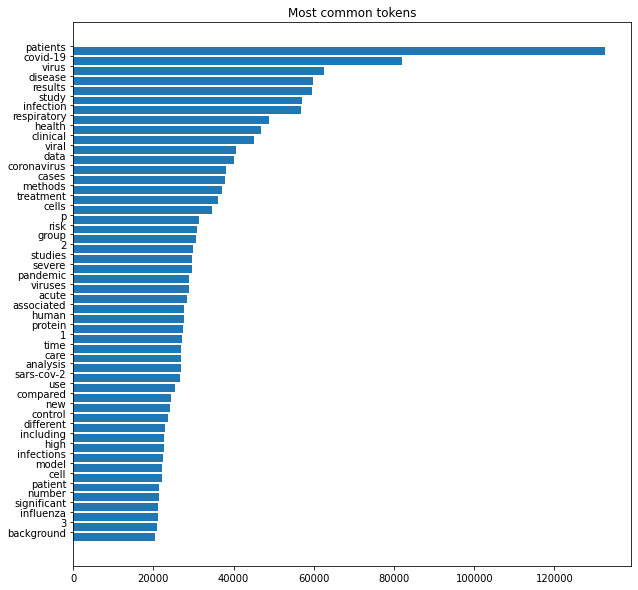

In [70]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata,column='cleand_text', title='Most common tokens')